# Imports and Constants

In [1]:
import rhythm_regression.audio_processing as ap
from rhythm_regression.audio_processing import SAMPLING_RATE, FRAME_SIZE, HOP_LENGTH, AMPLITUDE_THRESHOLD
import rhythm_regression.midi_processing as mp
import rhythm_regression.notebook_tools as nbt
from rhythm_regression.unit_conversion import MILLISECONDS_PER_SECOND
import rhythm_regression.vector_processing as vp

import librosa
import numpy as np
import matplotlib.pyplot as plt
import mido
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

SAMPLE_NUMS = list(range(1,101))
#SAMPLE_NUMS

# Data Loading

In [2]:
samples_table = pd.read_csv('./data/Samples.csv', index_col=0)
samples_table.head()

,sample_name,file,file format,midi_file,midi_file_name,tempo,in_time,composer,recorded with,Room,audible met,met type,player_met_aware,recorder_met_aware,correct_rhythm,notes
sample_id,,,,,,,,,,,,,,,,
1,Sample 1,./data/audio/Sample 1.m4a,m4a,./data/midi/Ram_8's_120bpm.mid,Ram_8's_120bpm.mid,120,True,Christian Kuhlman,iPhone 11,bedroom,False,metropitch,True,False,NaN,NaN
2,Sample 2,./data/audio/Sample 2.m4a,m4a,./data/midi/Ram_8's_120bpm.mid,Ram_8's_120bpm.mid,120,True,Christian Kuhlman,iPhone 11,bedroom,False,metropitch,True,False,NaN,NaN
3,Sample 3,./data/audio/Sample 3.m4a,m4a,./data/midi/Ram_8's_120bpm.mid,Ram_8's_120bpm.mid,120,True,Christian Kuhlman,iPhone 11,bedroom,False,metropitch,True,False,NaN,NaN
4,Sample 4,./data/audio/Sample 4.m4a,m4a,./data/midi/Ram_8's_120bpm.mid,Ram_8's_120bpm.mid,120,True,Christian Kuhlman,iPhone 11,bedroom,False,metropitch,True,False,NaN,NaN
5,Sample 5,./data/audio/Sample 5.m4a,m4a,./data/midi/Ram_8's_120bpm.mid,Ram_8's_120bpm.mid,120,True,Christian Kuhlman,iPhone 11,bedroom,False,metropitch,True,False,NaN,NaN


In [3]:
audios = np.array([librosa.load(samples_table.loc[sample_id]['file'])[0] for sample_id in tqdm(SAMPLE_NUMS)])
print([audio.shape for audio in audios])

100%|██████████| 100/100 [01:41<00:00,  1.02s/it]

[(663735,), (671732,), (670320,), (655738,), (667028,), (595056,), (585178,), (598820,), (587530,), (609168,), (531552,), (529671,), (496743,), (502388,), (510855,), (931863,), (919632,), (916810,), (903168,), (955383,), (851424,), (847661,), (847191,), (868829,), (844839,), (786039,), (801092,), (830727,), (798269,), (794506,), (754992,), (733824,), (753581,), (740880,), (736176,), (814263,), (777572,), (807207,), (786980,), (773338,), (744173,), (707952,), (735236,), (720183,), (728180,), (665616,), (653856,), (629396,), (644448,), (677847,), (603994,), (604464,), (601642,), (609168,), (632218,), (1073453,), (999600,), (1009949,), (982196,), (1033940,), (924807,), (906932,), (943152,), (918221,), (935626,), (888586,), (861773,), (883412,), (912576,), (894231,), (1091328,), (1072983,), (1085213,), (1097914,), (1056989,), (952560,), (994896,), (1006186,), (1003834,), (984548,), (881530,), (897994,), (892820,), (925277,), (897053,), (890468,), (793095,), (765341,), (761108,), (768634,),

# Variable Definitions

In [190]:
transient_vectors = np.array([ap.transients(audio) for audio in audios])
t_diffs = np.array([np.diff(t) for t in transient_vectors])
log_t_diffs = np.array([np.log(t_diff) for t_diff in t_diffs])

In [193]:
midis = [mido.MidiFile(samples_table.loc[sample_id]['midi_file']) for sample_id in SAMPLE_NUMS]
midi_vectors = np.array([mp.get_midi_vector(midi) for midi in midis])

# Rounding is necessary for some god forsaken reason
m_diffs = np.array([np.diff(m).round(4) for m in midi_vectors])

log_m_diffs = np.array([np.log(m_diff) for m_diff in m_diffs])
bpms = np.array([mp.get_bpm(midi) for midi in midis])

# Unique Rhythms

In [194]:
np.unique(np.hstack(m_diffs))

array([0.0682, 0.0714, 0.0725, 0.0769, 0.0833, 0.0909, 0.1071, 0.1087,
       0.1154, 0.125 , 0.1364, 0.1429, 0.1449, 0.15  , 0.1538, 0.1667,
       0.1786, 0.1818, 0.2143, 0.2174, 0.2222, 0.2308, 0.25  , 0.2727,
       0.2857, 0.2899, 0.3   , 0.3077, 0.3261, 0.3333, 0.3636, 0.4091,
       0.4348, 0.5455, 0.7273, 0.8182, 0.8696, 0.9545, 1.2273, 1.9091])

In [213]:
from matplotlib.pyplot import xlabel


num_unique_rhythms = [len(np.unique(m_diff)) for m_diff in m_diffs]
pd.DataFrame({'MIDI name': samples_table['midi_file_name'][SAMPLE_NUMS], 'unique_rhythms': num_unique_rhythms})

,MIDI name,unique_rhythms
sample_id,,
1,Ram_8's_120bpm.mid,1
2,Ram_8's_120bpm.mid,1
3,Ram_8's_120bpm.mid,1
4,Ram_8's_120bpm.mid,1
5,Ram_8's_120bpm.mid,1
6,Ram_8's_135bpm.mid,1
7,Ram_8's_135bpm.mid,1
8,Ram_8's_135bpm.mid,1
9,Ram_8's_135bpm.mid,1


Text(0.5, 1.0, 'Num Unique Rhythms per MIDI')

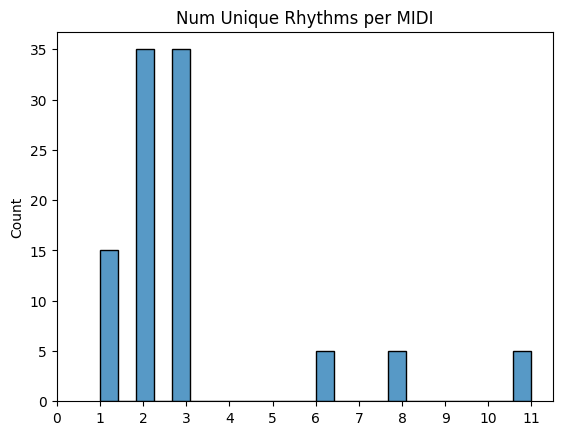

In [214]:
sns.histplot(num_unique_rhythms)
plt.xticks(list(range(12)))
plt.title('Num Unique Rhythms per MIDI')

# Marginal Distributions

<AxesSubplot: ylabel='Count'>

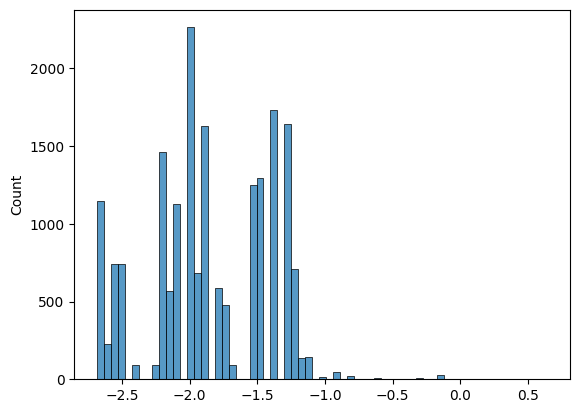

In [35]:
sns.histplot(np.log(np.hstack(m_diffs)))

In [7]:
min(bpms), max(bpms)

(100, 168)

Text(0.5, 1.0, '')

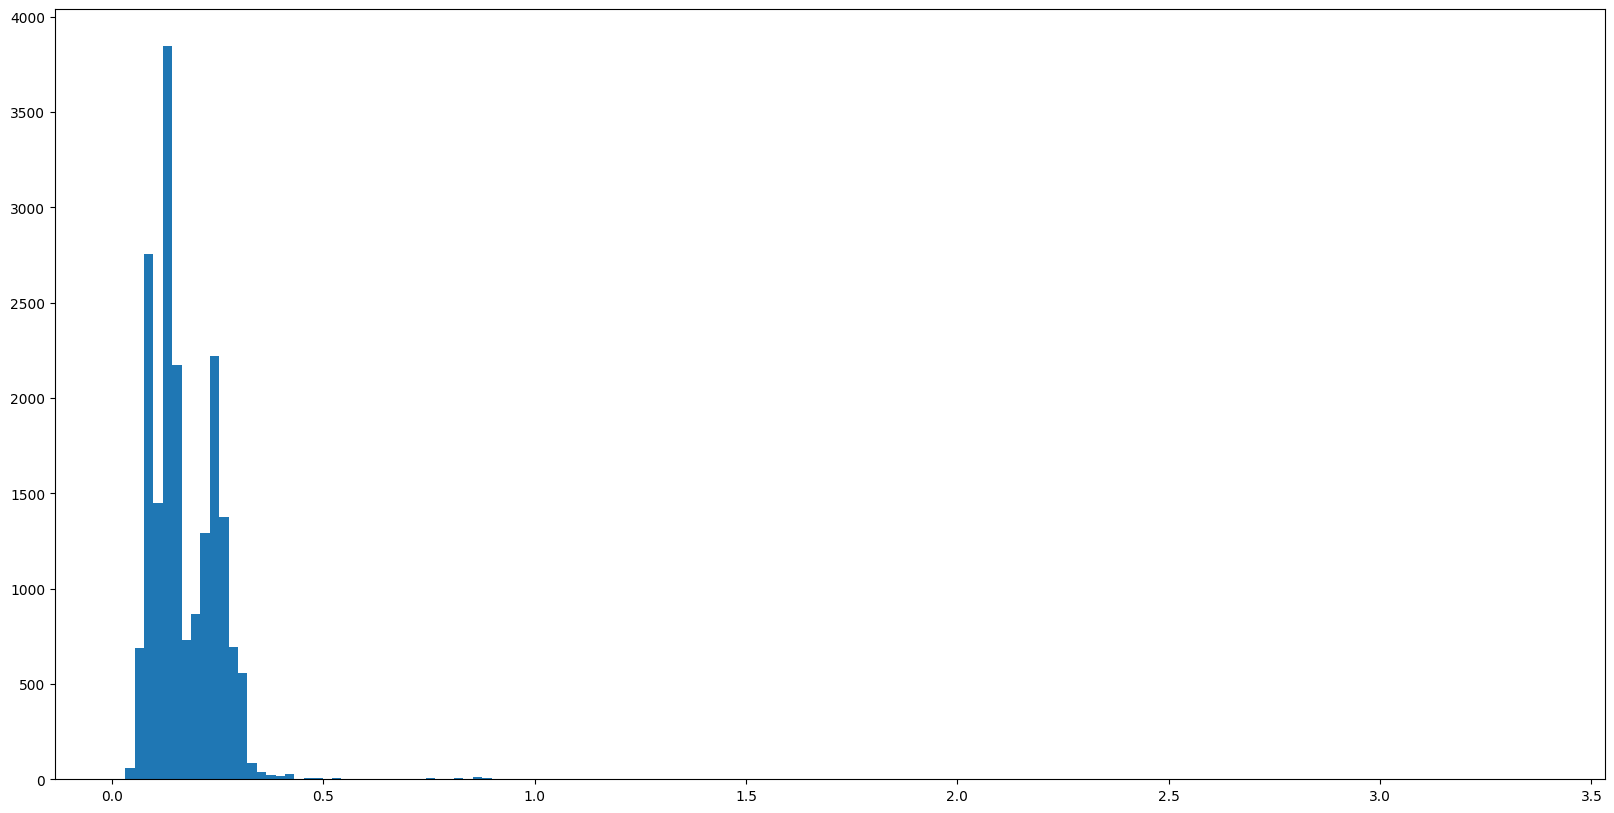

In [198]:
plt.figure(figsize=(20,10))

#plt.vlines(np.unique(np.hstack(m_diffs)), ymin=0, ymax=4000, linewidth=3, color='k')
plt.hist(np.hstack(t_diffs), bins=150)
plt.title('')

Text(0.5, 1.0, '')

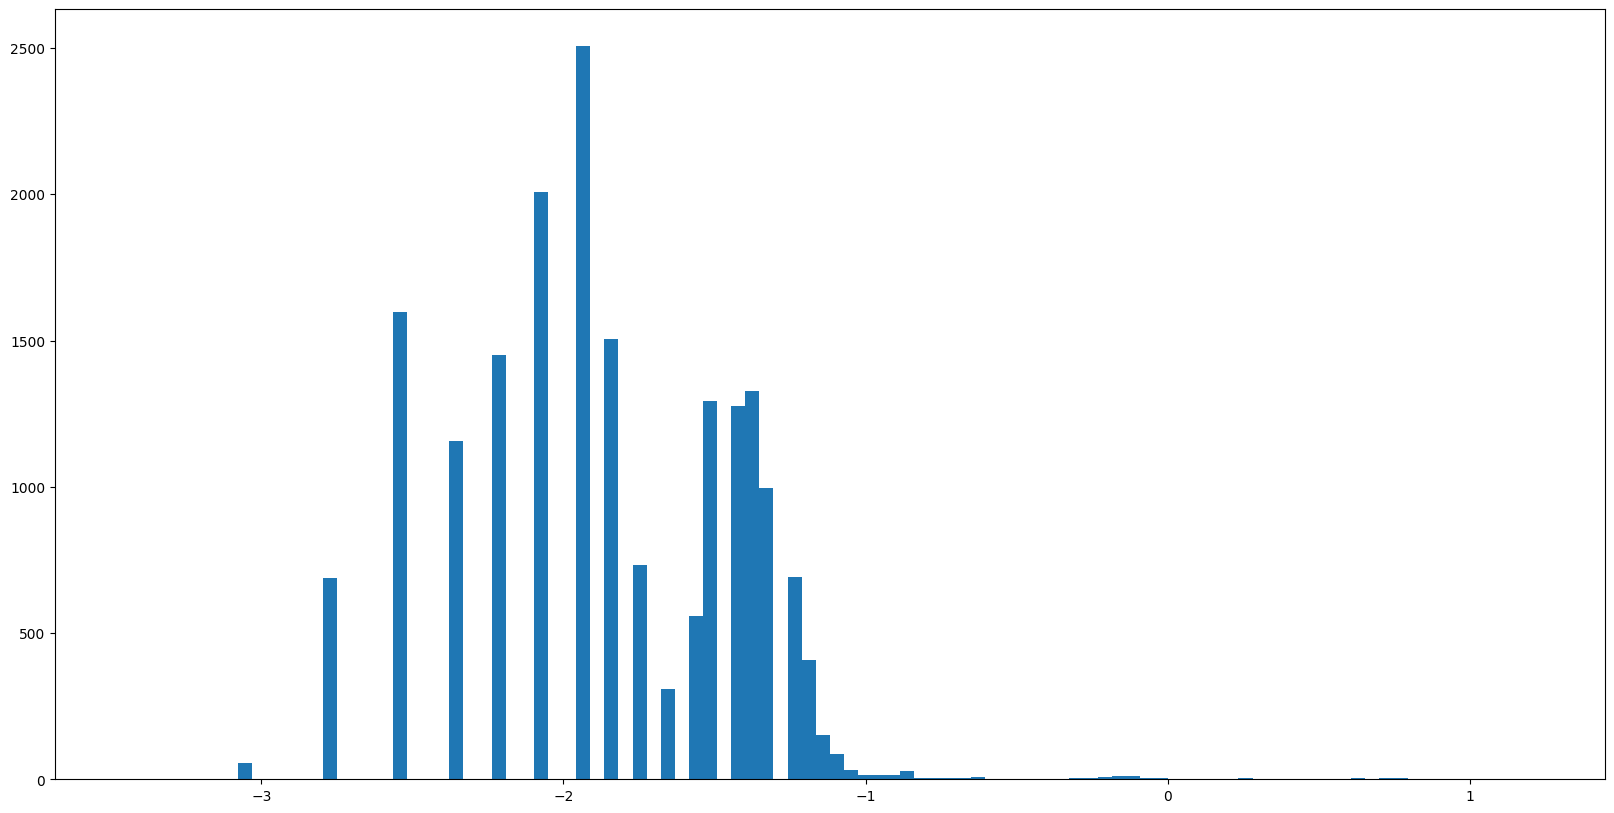

In [202]:
plt.figure(figsize=(20,10))

#plt.vlines(np.unique(np.hstack(log_m_diffs)), ymin=0, ymax=3000, linewidth=3, color='k')
plt.hist(np.hstack(log_t_diffs), bins=100)
plt.title('')

# Joint Distribution with Tempo

Text(0, 0.5, 'Log(Note Length) (s)')

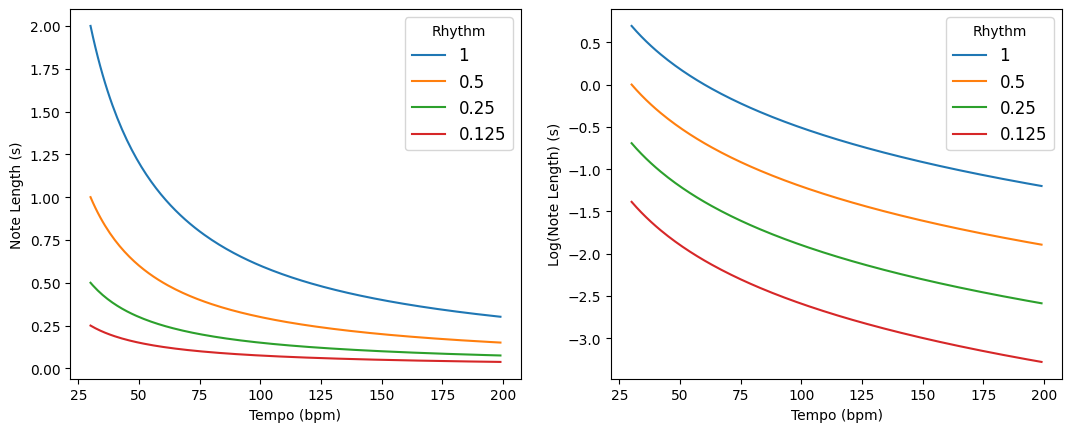

In [215]:
plt.figure(figsize=(12.8,4.8))

rhythms = [1, 0.5, 0.25, 0.125]
tempo = np.array(range(30, 200))

plt.subplot(1,2,1)
for rhythm in rhythms:
#   note_length = 60 * MILLISECONDS_PER_SECOND * rhythm / tempo
    note_length = 60 * rhythm / tempo
    plt.plot(tempo, note_length, label=rhythm)

plt.legend(title='Rhythm', fontsize=12)
plt.xlabel('Tempo (bpm)')
plt.ylabel('Note Length (s)')

plt.subplot(1,2,2)
for rhythm in rhythms:
#   note_length = 60 * MILLISECONDS_PER_SECOND * rhythm / tempo
    note_length = 60 * rhythm / tempo
    plt.plot(tempo, np.log(note_length), label=rhythm)

plt.legend(title='Rhythm', fontsize=12)
plt.xlabel('Tempo (bpm)')
plt.ylabel('Log(Note Length) (s)')

<AxesSubplot: xlabel='Tempo (bmp)', ylabel='Note Length (ms)'>

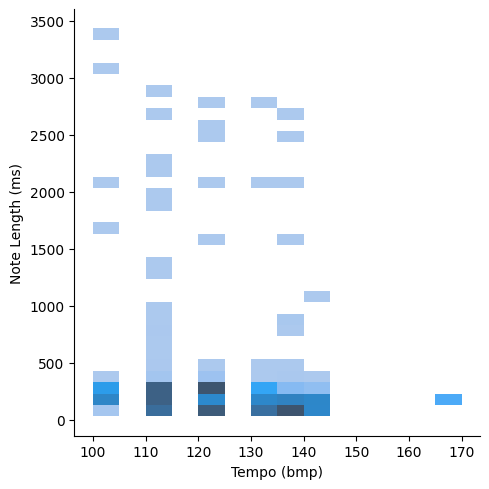

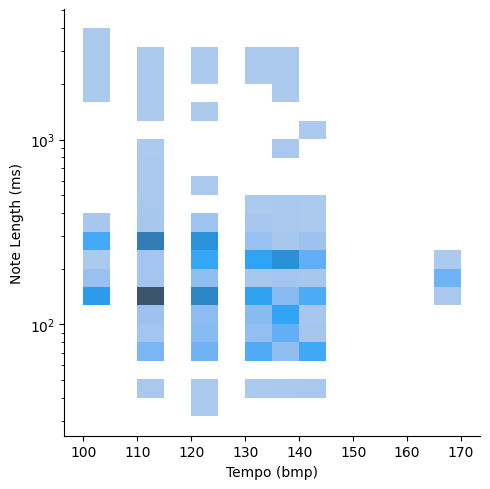

In [201]:
def plot_rhythm_distribution(t_vectors, tempos, log_rhythm=True, units='s', rhythm_bin_width=None):


    t_diffs = [np.diff(t) for t in transient_vectors]
    
    if units == 'ms':
        t_diffs = [t_diff * MILLISECONDS_PER_SECOND for t_diff in t_diffs] 
        if rhythm_bin_width is not None:
            rhythm_bin_width *= MILLISECONDS_PER_SECOND
    elif units == 's':
       pass 
    else:
        raise ValueError(f'Units must be one of [\'s\', \'ms\'], got \'{units}\' instead.')


    rhythm_df = pd.DataFrame({f'Note Length ({units})': np.hstack(t_diffs), 
                              'Tempo (bmp)': np.repeat(tempos, [len(t_diff) for t_diff in t_diffs])})

    facet_grid = sns.displot(rhythm_df, x='Tempo (bmp)', y=f'Note Length ({units})', 
                      log_scale=(False, log_rhythm), binwidth=(5, rhythm_bin_width))

    return facet_grid.axes[0][0]


plot_rhythm_distribution(transient_vectors, bpms, units='ms', log_rhythm=False, rhythm_bin_width=0.1)
plot_rhythm_distribution(transient_vectors, bpms, units='ms', rhythm_bin_width=0.0001)